In [9]:
import matplotlib.pylab as plt
import numpy as np
import pickle
from tqdm import tqdm
import random

from matplotlib import image
from matplotlib import pyplot
from matplotlib.pyplot import figure

from scipy.ndimage import gaussian_filter1d

%matplotlib inline

In [10]:
T = np.load("curves.npy")
print(T.shape)

Labels = np.load('labels.npy', allow_pickle=True)
print(Labels.shape)


(500, 256)
(500, 7)


In [11]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import poisson

def noise_injection(xrr_curve):
    cps = random.choice([5e9, 9e9])
    q = np.linspace(0.015, 0.35, 256)
    xrr_curve_q = xrr_curve*(q**4)
    noisyr = poisson.rvs(mu=xrr_curve_q*cps, size=256)/cps  # RM
    noisyr[noisyr <= 1e-9] = 1e-9
    return noisyr/(q**4)

def noise_injection2(xrr_curve):
    xrr_curve_n = xrr_curve
    cps = random.choice([2e8, 6e8])
    q = np.linspace(0.015, 0.35, 256)
    for i in range(256):
        if i<=59:
            xrr_curve_n[i] = xrr_curve_n[i]/1934
        if i>59 and i<=63:
            xrr_curve_n[i] = xrr_curve_n[i]/130.5
        if i>63 and i<=117:
            xrr_curve_n[i] = xrr_curve_n[i]/10.5
        else:
            xrr_curve_n[i] = xrr_curve_n[i]

    xrr_curve_q = xrr_curve_n
    noisyr = poisson.rvs(mu=xrr_curve_q*cps, size=256)/cps  # RM
    noisyr[noisyr <= 2e-8] = 2e-8
    for i in range(256):
        if i<=59:
            noisyr[i] = noisyr[i]*1934
        if i>59 and i<=63:
            noisyr[i] = noisyr[i]*130.5
        if i>63 and i<=117:
            noisyr[i] = noisyr[i]*10.5
        else:
            noisyr[i] = noisyr[i]
    noisyr[noisyr <= 2e-7] = 2e-7
    return noisyr

def scaling(xrr_curve, min_scale=0.95, max_scale=1.05):
    scale_factor = np.random.uniform(min_scale, max_scale)
    return xrr_curve * scale_factor

def shift(xrr_curve, max_shift=1.1):
    shift_amount = np.random.randint(-max_shift, max_shift)
    return np.roll(xrr_curve, shift_amount)

def rotation(xrr_curve, max_rotation=5):
    rotation_amount = np.random.uniform(-max_rotation, max_rotation)
    return np.interp(np.linspace(0, 1, len(xrr_curve)), np.linspace(0, 1, len(xrr_curve)), np.roll(xrr_curve, int(rotation_amount)))

def random_segment_drop(xrr_curve, min_segments=1, max_segments=3, min_drop_length=2,
                        max_drop_length=10):
    num_segments_to_drop = np.random.randint(min_segments, max_segments + 1)
    dropped_curve = np.copy(xrr_curve)
    
    # Start the first drop within the specified range
    drop_start = np.random.randint(15, 25)
    gap_between_drops = np.random.randint(22, 30)  # Choose a random gap between drops
    
    for _ in range(num_segments_to_drop):
        drop_length = np.random.randint(min_drop_length, max_drop_length + 1)
        dropped_curve[drop_start:drop_start + drop_length] = np.nan
        
        # Update drop_start for the next drop
        drop_start += gap_between_drops
        
        # Ensure the next drop doesn't exceed the array length
        if drop_start + max_drop_length >= len(xrr_curve):
            break

    dropped_curve = interpolate_missing_values(dropped_curve)
    return dropped_curve

def remove_points_around_indices(xrr_curve, indices, points_around=2):
    modified_curve = np.copy(xrr_curve)
    for index in indices:
        start = max(index - points_around, 0)
        end = min(index + points_around + 1, len(xrr_curve))
        modified_curve[start:end] = np.nan
    modified_curve = interpolate_missing_values(modified_curve)
    return modified_curve

def interpolate_missing_values(xrr_curve):
    q = np.linspace(0.015, 0.35, 256)
    xrr_curve = xrr_curve * (q ** 4)
    missing_indices = np.isnan(xrr_curve)
    valid_indices = np.where(~missing_indices)[0]
    interp_func = interp1d(valid_indices, xrr_curve[~missing_indices], kind='linear', fill_value='extrapolate')
    xrr_curve[missing_indices] = interp_func(np.where(missing_indices)[0])
    return xrr_curve / (q ** 4)

def apply_smearing(y, dq_percentage):
    # dq_percentage: smearing percentage of the point resolution
    sigma = (dq_percentage / 100) * len(y)
    smeared_y = gaussian_filter1d(y, sigma=sigma)
    return smeared_y



In [12]:
from multiprocessing import  Process, Queue, Lock

target=T
#print(target)

from scipy.stats import poisson
from numpy import inf
n_T = []
noisyr =[]
lab_n = []

batch_size = 500

indices = [31 ,59, 117]
for a in tqdm(range(batch_size)):
    # xrr_curve = T[1+a,:] #R
    xrr_curve = T[a,:] #RM
    # Apply data augmentation
    #augmented_xrr_curve = xrr_curve
    #augmented_xrr_curve = apply_smearing(xrr_curve, 0.0)
    augmented_xrr_curve = noise_injection(xrr_curve)
    augmented_xrr_curve = noise_injection2(augmented_xrr_curve)
    #augmented_xrr_curve = noise_injection2(xrr_curve)
    augmented_xrr_curve = scaling(augmented_xrr_curve)
    augmented_xrr_curve = random_segment_drop(augmented_xrr_curve, min_segments=7, max_segments=12,
                                            min_drop_length=2, max_drop_length=4)
    augmented_xrr_curve = remove_points_around_indices(augmented_xrr_curve, indices)
    n_T.append(augmented_xrr_curve)
    labels_n = Labels[a,:]
    lab_n.append(labels_n)


# print(data_all(['curves']).shape)
data_all = np.array(n_T)
label_all = np.array(lab_n)


#print(data_all[0,:])

print(data_all.shape, label_all.shape)

100%|██████████| 500/500 [00:00<00:00, 857.79it/s]

(500, 256) (500, 7)


In [13]:
print(np.transpose(data_all).shape)

ntarget_a = np.reshape(data_all, [500,256])
label_a = np.reshape(label_all, [500,7])
#ntarget_a = np.transpose(ntarget_a)
print(ntarget_a.shape)

(256, 500)
(500, 256)


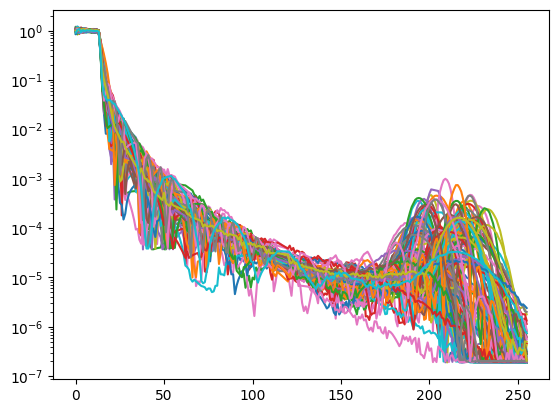

(1000, 256)
(1000, 7)


In [14]:
for i in range (100):
    plt.plot(ntarget_a[i+100,:])
    plt.yscale('log')
plt.show()

T = np.load("curves.npy")
T = np.append(T, ntarget_a, axis=0)

T = np.array(T, dtype='float32')
print(T.shape)
np.save("curves_N.npy", T, allow_pickle=True)

labels_N = np.append(Labels, label_a, axis=0) #RM   
print(labels_N.shape)      
np.save("labels_N.npy", labels_N, allow_pickle=True)

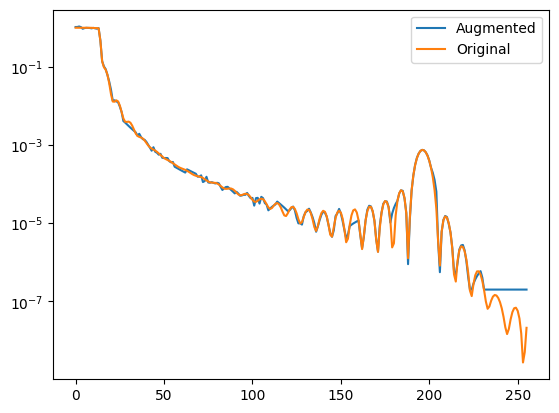

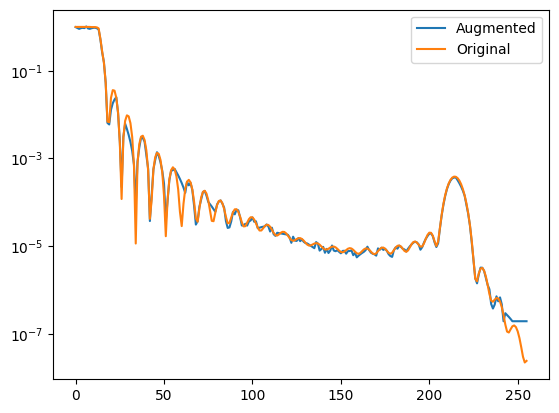

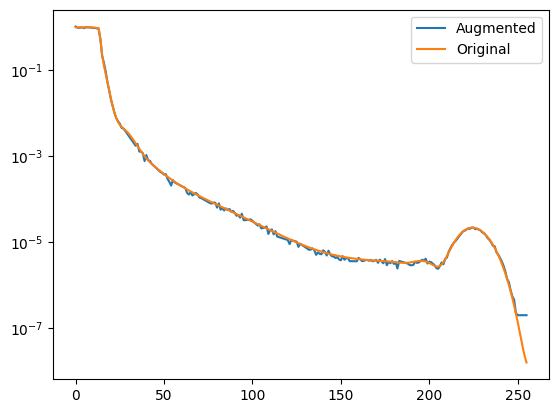

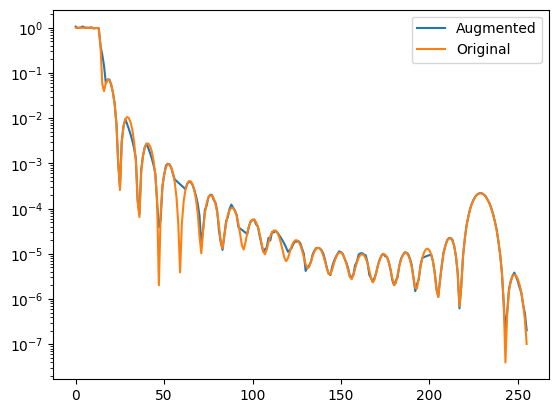

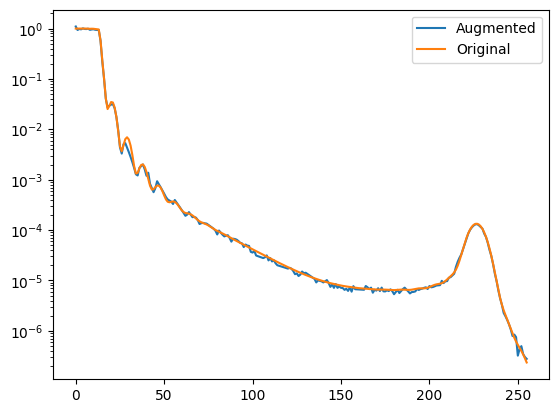

In [15]:
for i in range (5):
    plt.plot(ntarget_a[i+10,:], label='Augmented')
    plt.plot(T[i+10,:], label='Original')
    plt.yscale('log')
    plt.legend()
    plt.show()

